In [147]:
# let's import any libraries that we need
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [148]:
# load the dataset and display the head
df = pd.read_csv('data/AppleStore.csv', index_col=0)
df.head()

,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [149]:
# let's check to see if we're missing any data and remove some columns we don't need
df = df.drop(columns=['id','size_bytes','currency','rating_count_ver','user_rating_ver','ver','vpp_lic'])
df.info()
# it looks all good!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7197 entries, 1 to 11097
Data columns (total 9 columns):
track_name          7197 non-null object
price               7197 non-null float64
rating_count_tot    7197 non-null int64
user_rating         7197 non-null float64
cont_rating         7197 non-null object
prime_genre         7197 non-null object
sup_devices.num     7197 non-null int64
ipadSc_urls.num     7197 non-null int64
lang.num            7197 non-null int64
dtypes: float64(2), int64(4), object(3)
memory usage: 562.3+ KB


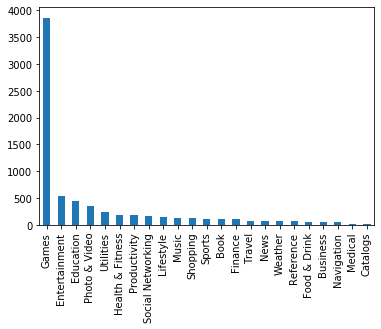

In [150]:
df['prime_genre'].value_counts().plot(kind='bar');

In [151]:
# one hot the genre of the app (game, education, social networking, etc...)
one_hot = pd.get_dummies(df['prime_genre'])
temp_df = df.drop('prime_genre',axis=1)
temp_df = temp_df.join(one_hot)
df = temp_df

# one hot the age rating (4+, 9+, 12+, 17+)
one_hot = pd.get_dummies(df['cont_rating'])
temp_df = df.drop('cont_rating',axis=1)
temp_df = temp_df.join(one_hot)
df = temp_df

# Great! Now we have all numerical data, except for the name. But that's no issue since we wont use the name in our regression
# let's see our new columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7197 entries, 1 to 11097
Data columns (total 34 columns):
track_name           7197 non-null object
price                7197 non-null float64
rating_count_tot     7197 non-null int64
user_rating          7197 non-null float64
sup_devices.num      7197 non-null int64
ipadSc_urls.num      7197 non-null int64
lang.num             7197 non-null int64
Book                 7197 non-null uint8
Business             7197 non-null uint8
Catalogs             7197 non-null uint8
Education            7197 non-null uint8
Entertainment        7197 non-null uint8
Finance              7197 non-null uint8
Food & Drink         7197 non-null uint8
Games                7197 non-null uint8
Health & Fitness     7197 non-null uint8
Lifestyle            7197 non-null uint8
Medical              7197 non-null uint8
Music                7197 non-null uint8
Navigation           7197 non-null uint8
News                 7197 non-null uint8
Photo & Video        7197 

In [152]:
corr = df.corr()['user_rating'].sort_values(ascending=False)
# Interstingly, it looks like apps that had more screenshots and supported more languages tended to have higher ratingings.
# However, apps that were rated "17+" tended to have more negative ratings.
corr

user_rating          1.000000
ipadSc_urls.num      0.265671
lang.num             0.170976
Games                0.112055
rating_count_tot     0.083310
9+                   0.063706
Productivity         0.050220
price                0.046601
Music                0.041573
Photo & Video        0.040738
4+                   0.036044
Health & Fitness     0.018260
Business             0.012871
12+                  0.011439
Weather              0.004654
Shopping             0.001214
Reference           -0.004607
Medical             -0.005871
Travel              -0.010573
Food & Drink        -0.021324
Education           -0.025711
Utilities           -0.030958
Catalogs            -0.035068
News                -0.036979
sup_devices.num     -0.042451
Navigation          -0.044501
Sports              -0.045511
Entertainment       -0.052319
Social Networking   -0.055029
Lifestyle           -0.067912
Book                -0.086917
Finance             -0.087297
17+                 -0.155323
Name: user

user_rating         1.000000
ipadSc_urls.num     0.265671
lang.num            0.170976
Games               0.112055
rating_count_tot    0.083310
Book               -0.086917
Finance            -0.087297
17+                -0.155323
Name: user_rating, dtype: float64


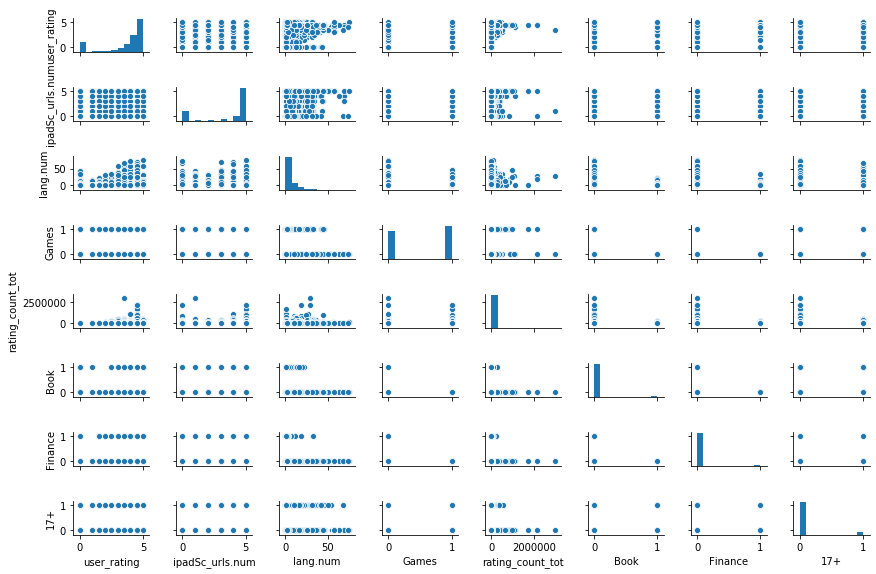

In [153]:
# let's take out factors that don't have ant correlation with rating
relevant_features = corr[abs(corr) > 0.07]
print(relevant_features.sort_values(ascending=False))
sns.pairplot(df[relevant_features.index], height = 1, aspect=1.5)

In [157]:
'''
X = df[relevant_features.index]
X['log_user_rating'] = np.log(X['user_rating'].replace(0, np.nan))
X = X.drop(columns = ['user_rating'])
X = X.fillna(0)

print('test')

sns.pairplot(X, height = 1, aspect=1.5)
'''

model = LinearRegression()
#y = X['log_user_rating']
y = X['user_rating']
#X = X.drop('log_user_rating', axis = 1)
X = X.drop('user_rating', axis = 1)
#y.fillna(0)
#X.fillna(0)
print(y.head())
print(X.head())
model.fit(X,y)
print(f"Adjusted R^2: {1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)}")
print(f"m = {model.coef_}")
print(f"b = {model.intercept_}")

KeyError: 'user_rating'

In [ ]:
y_scatter = y

ax = plt.subplot()
x_scatter = X['ipadSc_urls.num']
plt.scatter(x_scatter,y_scatter)
plt.title('NUMER OF SCREEN SHOTS ON APP STORE')
plt.show()

ax = plt.subplot()
x_scatter = X['lang.num']
plt.scatter(x_scatter,y_scatter)
plt.title('NUMER OF LANGUAGES SUPPORTED')
plt.show()

ax = plt.subplot()
x_scatter = X['rating_count_tot']
plt.scatter(x_scatter,y_scatter)
plt.title('NUMER OF RATINGS')
plt.show()

In [ ]:
# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(model, ax, x_plot, y, label=None):
    """Plot the approximation of ``model`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), 'g', label="ground truth")
    ax.scatter(x_plot, y, s=10)
    x = x_plot[:, np.newaxis]
    ax.plot(x_plot, model.predict(x), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right')

In [ ]:
degree = 3
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
X = X[:, np.newaxis]
model.fit(X['rating_count_tot'], y)

plot_approximation(model, ax, X_plot, y, label='degree=%d' % degree)